# Analysis for Zeisel's 3005 mouse brain cells

Aftering obtaining a transcript compatibility count (TCC) distribution matrix by running the pipeline, we use the matrix to:

1. <a href='#section1'> Cluster cells </a>
2. <a href='#section2'> Determine the accuracy of clustering </a>
3. <a href='#section3'> Analyze Zeisel et al.'s Oligo1 cells </a>
4. <a href='#section4'> Take a closer look at Zeisel et al.'s Oligo3 cells </a>
5. <a href='#section5'> Analyze accuracy of clustering as the number of reads decreases </a>

We will show how we accomplish each of these below.

## Running the pipeline and inputting the data matrices

We have provided the script get_files.py to download the SRA files to ./SRA_files/ . 

In [ ]:
os.system('python get_files.py')

The following input paths are required:

* path to the SRA directory
* path to the modified single-end kallisto
* path to the mouse transcriptome

Make sure to also set the number of processes to use.

In [ ]:
# Directory with SRA files
SRA_dir='./SRA_files/'

# Path to our version of kallisto that outputs transcript compatibility counts
modified_kallisto_path='/data/SS_RNA_seq/Code/kalliPso'

# Path to transcriptome
transcriptome_path='/data/SS_RNA_seq/Zeisel/reference_transcriptome/Mus_musculus.GRCm38.rel79.cdna.all.fa'

num_processes=32

First run the pipeline, which may take a few hours. Starting with all the SRA files, the pipeline generates the transcript compatibility count matrix using kallisto and then uses it to compute a distance matrix. The pipeline also runs other tools and generates the pairwise Jensen-Shannon distance matrices for their outputs as well. All design and sitance matrices are saved using the Python Pickle module. The five different methods used to obtain design matrices used for clustering are: 

1. kallisto  
2. eXpress
3. UMI counting (Zeisel's approach)
4. TCC
5. TCC with UMIs collapsed

We note that methods 2 and 3 requires read alignment first, which is done by the pipeline using Bowtie. The other methods use pseudoalignment. The pipeline also subsamples reads and computes a distance matrix for each subsampling for each of the above 5 methods. The purpose of this is to analyze how clustering accuracy changes with coverage (see last section of this notebook on coverage analysis). The following subsamplings are investigated: 0.1, 0.5, 1, 5, 10, and 100% of the original reads..

In [ ]:
os.system('python Zeisel_wrapper.py -i '+SRA_dir+
         ' -k '+modified_kallisto_path+ ' -n ' 
          + str(num_processes)+' -t '+ transcriptome_path)

For the following analysis, we load in the obtained TCC pairwise distance matrix (3005-by-3005 matrix) and sets of labels from the authors (3005-by-1 vectors). We also load in all coverage-related distance matrices as they are used in the Clustering Accuracy and Coverage Analysis sections.

In [166]:
import pickle
import numpy as np
with open('Zeisel_TCC_pairwise_JS_distance_subsample100_full.dat','rb') as infile:
    D = pickle.load(infile)
    
# Zeisel's 9 main clusters
labels9 = np.loadtxt('./Zeisels_data/Zeisels_labels9.txt',dtype=str).astype(int)-1

# Zeisel's neurons (labeled as 0) and non-neurons (labeled as 1) obtained from labels9
labels2 = np.copy(labels9)
for i in [0,1,2]: labels2[labels2 == i] = 0
labels2[labels2 != 0] = 1

# Zeisel's 47 total clusters
labels47 = np.loadtxt('./Zeisels_data/Zeisels_labels47.txt',dtype=str)

# Distance matrices are all saved in an object called D_all where D_all[i,j] 
# corresponds the distance matrix obtained using method i and subsampling j
# Note: this is a 5x6x3005x3005 object

methods = ['kallisto_gene_pairwise_SJ','express_distance','UMI_gene_pairwise',
           'TCC_pairwise_JS_distance','TCC_UMI_pairwise_JS']
subsamplings = ['_point1','_point5','1','5','10','100']

nm,ns = len(methods),len(subsamplings)
D_all = [[[] for j in range(ns)] for i in range(nm)]
for i,j in itertools.product(range(nm),range(ns)):
    D = pickle.load(file('./Zeisel_'+methods[i]+'_subsample'+subsamplings[j]+'.dat','rb'))
    if scipy.sparse.issparse(D): D = D.todense()
    D_all[i][j] = D

## Clustering  <a id='section1'></a>

Clustering was performed using both spectral clustering (when the number of clusters is known) and affinity propagation (when the number of clusters is unknown). First, a low-dimensional embedding of the data is obtained using the precomputed distances and t-SNE:

In [2]:
%%time
from sklearn import manifold
def tSNE_pairwise(D):
    tsne = manifold.TSNE(n_components=2, random_state=0, metric='precomputed', n_iter=2000, verbose=1);
    X_tsne = tsne.fit_transform(D);
    return X_tsne
X_tsne = tSNE_pairwise(D)

[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 3000 / 3005
[t-SNE] Computed conditional probabilities for sample 3005 / 3005
[t-SNE] Mean sigma: 0.082504
[t-SNE] Error after 65 iterations with early exaggeration: 22.858847
[t-SNE] Error after 141 iterations: 2.182714
CPU times: user 1min 23s, sys: 8.62 s, total: 1min 31s
Wall time: 1min 31s


We first visualize the data using t-SNE and the authors' 9 labels.

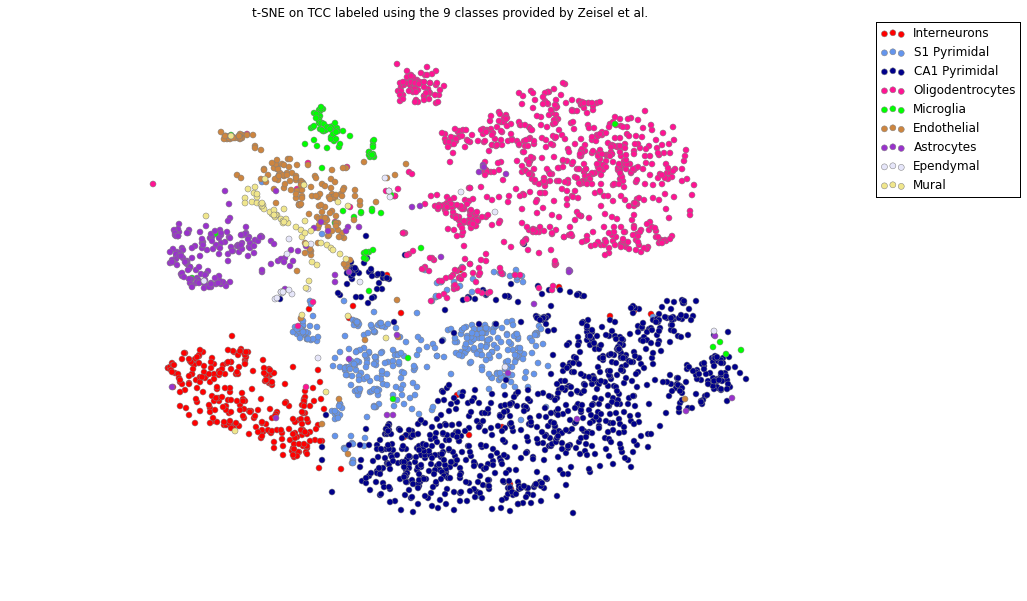

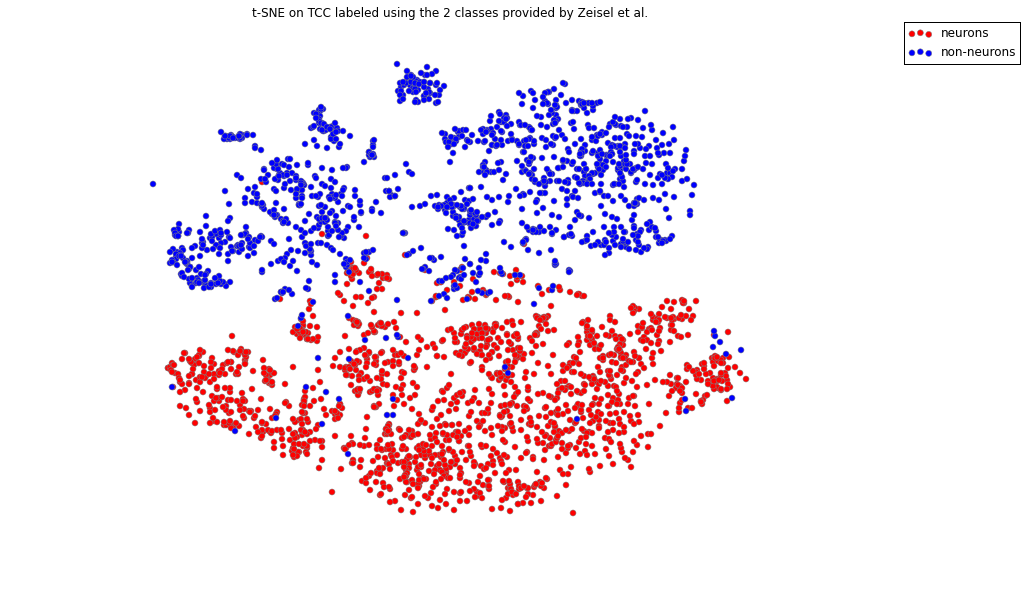

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
# Plot function with Zeisel's colors corresponding to labels 
def tru_plot9(X,labels,t,clust_names,clust_color):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    for i in unique_labels:
        ind = np.squeeze(labels == i)
        plt.scatter(X[ind,0],X[ind,1],c=clust_color[i],s=36,edgecolors='gray',
                    lw = 0.5, label=clust_names[i])        
    plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1))
    plt.legend(loc='upper right',bbox_to_anchor=(1.19, 1.01))
    plt.title(t)
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.axis('off')
    
tru_plot9(X_tsne,labels9,
         't-SNE on TCC labeled using the 9 classes provided by Zeisel et al.',
         clust_names = ['Interneurons','S1 Pyrimidal','CA1 Pyrimidal','Oligodentrocytes',
                   'Microglia','Endothelial','Astrocytes','Ependymal','Mural'],
         clust_color = ['red','cornflowerblue','darkblue','deeppink','lime',
                   'peru','darkorchid','lavender','khaki'])
tru_plot9(X_tsne,labels2,
         't-SNE on TCC labeled using the 2 classes provided by Zeisel et al.',
         clust_names = ['neurons','non-neurons'],
         clust_color = ['red','blue'])

Next, we cluster the cells using several approaches: spectral clustering for both k = 9 and k = 47, and affinity propagation with various parameters. We note here that spectral clustering can generate different results in different runs due to randomness. 

In [32]:
from sklearn import cluster

# obtain labels via spectral clustering
def spectral(k,D):
    if D[1,1] < 1: D = 1-D # Convert distance to similarity matrix
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels

tcc_spectral_labels2 = spectral(2,D)
tcc_spectral_labels9 = spectral(9,D)
tcc_spectral_labels47 = spectral(47,D)

# obtain labels via affinity propagation
def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

pref = -np.median(D.flatten())*np.ones(3005)
tcc_affinity_labels1 = AffinityProp(-D,pref,0.5)
tcc_affinity_labels2 = AffinityProp(-D,2*pref,0.7)

Converged after 28 iterations.
Converged after 32 iterations.


## Clustering Accuracy  <a id='section2'></a>

To determine the accuracy of clustering, we match the obtained cluster labels to Zeisel's labels. Because Zeisel et al. both created the dataset and were the ones to carefully craft methods for analyzing the data, we take their labels to be truth for now. 

Given a set of truth labels, we measure the accuracy of another set of labels using the [Kuhn Munkres max-weight matching algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm). We scale the output of this algorithm such that we get an error rate. Specifically, we output the proportion of cells that are still incorrectly labeled after matching the labels. 

In [94]:
import networkx as nx
import itertools

# gets max weight matching of a biparetite graph with row_label x column_label
# (weights are given by weight_matrix)
def get_max_wt_matching(row_label,column_label, weight_matrix):
    # Create a bipartite graph where each group has |unique labels| nodes 
    G = nx.complete_bipartite_graph(len(row_label), len(column_label))
    # Weight each edge by the weight in weight matrix.. 
    for u,v in G.edges(): G[u][v]["weight"]=weight_matrix[u,v-len(row_label)]
    # Perform weight matching using Kuhn Munkres
    H=nx.max_weight_matching(G)
    max_wt=0
    for u,v in H.items(): max_wt+=G[u][v]["weight"]/float(2)
    return max_wt

def compute_clustering_accuracy(label1, label2):
    uniq1,uniq2 = np.unique(label1),np.unique(label2)
    # Create two dictionaries. Each will store the indices of each label
    entries1,entries2 = {},{}
    for label in uniq1: entries1[label] = set(np.flatnonzero((label1==label)))
    for label in uniq2: entries2[label] = set(np.flatnonzero((label2==label)))
    # Create an intersection matrix which counts the number of entries that overlap for each label combination        
    W = np.zeros((len(uniq1),len(uniq2)))
    for i,j in itertools.product(range(len(uniq1)),range(len(uniq2))):
        W[i,j]=len(entries1[uniq1[i]].intersection(entries2[uniq2[j]]))
    # find the max weight matching
    match_val = get_max_wt_matching(uniq1,uniq2,W)
    # return the error rate
    return (1-match_val/float(len(label1)))*100

c2 = compute_clustering_accuracy(tcc_spectral_labels2,labels2)
print 'Spectral clustering with TCCs achieved an error rate of ' + str(c2) + '% (2 labels).'
c9 = compute_clustering_accuracy(tcc_spectral_labels9,labels9)
print 'Spectral clustering with TCCs achieved an error rate of ' + str(c9) + '% (9 labels).'

Spectral clustering with TCCs achieved an error rate of 2.59567387687% (2 labels).
Spectral clustering with TCCs achieved an error rate of 38.7021630616% (9 labels).


To further test the robustness of clustering, we sampled cells from each of two of Zeisel's cell types. We then clustered and recomputed the clustering accuracy. This process was repeated 10 times to account for the randomness associated with with sampling (monte carlo approach). This code may take a few minutes to run (set "report_time" to True in the "run_mc_simulation" function to get updates on how the the code is doing).

We look at the distance matrices performance clustering three types of cells:

* Zeisel's 45 Oligo1 and 106 Oligo4 cells
* Zeisel's 1628 neurons and 1377 non-neurons
* Zeisel's 290 interneurons and 198 astrocytes

We sampled *N* cells from each subtype where *N* equals half the number of cells in the smaller population rounded down. In the case where *N* is greater than 200, we set it equal to 200. Because a *N*-by-*N* distance matrix needs to be computed each time, large values of *N* will result in severely increased computation costs.

In [127]:
import time,scipy

# For a certain subset of labels, randomly sample cells from each label in subset
def get_indices_for_subset(labels,subsets,rseed=0,minc=200):
    np.random.seed(rseed)
    # Sample "min_count" number of cells from each label 
    min_count = min(minc,round(min([np.sum(labels == i) for i in subsets])/2))
    indices = []
    for label in subsets:
        temp = np.where(labels == label)[0]
        indices.append(np.random.choice(temp,min_count,replace=False))
    return np.sort(np.concatenate(indices))

# Truncate data to just the subsets of interest
def truncate_data(labels,subsets,X,D,rseed=0,minc=0):
    ind = get_indices_for_subset(labels,subsets,rseed,minc)
    return X[ind,:],D[np.ix_(ind,ind)],labels[ind],ind

# Given a distance matrix, some indices of interest, and the truth labels:
#  compute clustering accuracy after clustering with the distance matrix
def score_D(ind,L,Ds):
    if scipy.sparse.issparse(Ds): Ds = Ds.todense()
    Ds = Ds[np.ix_(ind,ind)]
    labels_s = spectral(2,Ds)
    match_val = compute_clustering_accuracy(L,labels_s)
    return match_val

# Wrapper for executing the experiment multiple times and timing each iteration
# (mc stands for "monte carlo" here)
def run_mc_simulation(subsets,labels,D,num_iter=10,mc=0,report_time=False):
    tot_score = []
    start_time = time.time()
    for i in range(num_iter):
        rs = np.random.randint(0,4294967294)
        # Truncate data
        ind = get_indices_for_subset(labels,subsets,rseed=rs,minc=mc)
        # Score labels
        tot_score.append(score_D(ind,labels[ind],D))
        if report_time: print 'Iteration: ' + str(i) + '   Time since start: ' + str(time.time()-start_time)
    return np.array(tot_score)

exp1_o1_v_o4 = run_mc_simulation(['Oligo1','Oligo4'],labels47,D)
exp2_n_v_nn = run_mc_simulation([0,1],labels2,D)
exp3_a_v_i = run_mc_simulation([6,0],labels9,D)
print 'Mean accuracy when clustering Oligo1 and Oligo4: ' + str(np.mean(exp1_o1_v_o4))
print 'Mean accuracy when clustering neurons and non-neurons: ' + str(np.mean(exp2_n_v_nn))
print 'Mean accuracy when clustering astrocytes and interneurons: ' + str(np.mean(exp3_a_v_i))

Mean accuracy when clustering Oligo1 and Oligo4: 16.5909090909
Mean accuracy when clustering neurons and non-neurons: 3.325
Mean accuracy when clustering astrocytes and interneurons: 0.959595959596


We visualize the clustering accuracy using a bar plot and compare it to clustering accuracies obtained with distance matrices produced by other methods. We note that the UMI counting, TCC, and TCC with UMI (TCC counting unique UMIs rather than reads) methods each consistently achieve 1% error rate and below (for astrocytes v. interneurons) while kallisto and eXpress do worse. The exactly error rates may fluctuate due to randomness. The distance matrices we list here were obtained using the tool listed in the comments below.

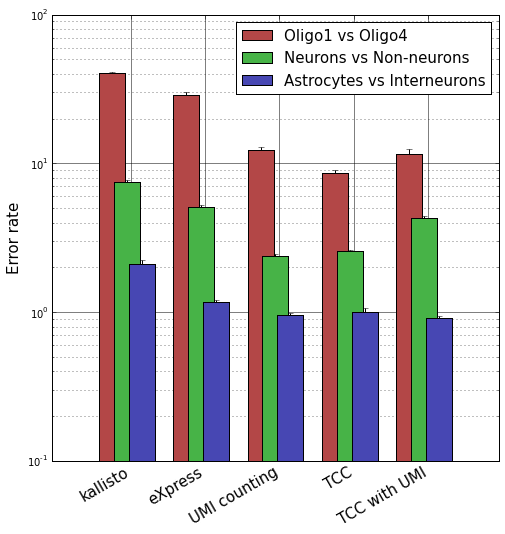

In [249]:
# Run clustering accuracy experiments
def run_mc_on_all_methods(labels,subsets,D_all):
    curves = []
    for i in range(5):
        D = D_all[i][5]
        curves.append(run_mc_simulation(subsets,labels,D))
    return curves

curves_o1_v_o4 = run_mc_on_all_methods(labels47,['Oligo1','Oligo4'],D_all)
curves_n_v_nn = run_mc_on_all_methods(labels2,[0,1],D_all)
curves_a_v_i = run_mc_on_all_methods(labels9,[6,0],D_all)

# Plot everything using a bar plot
import colorsys
def bars_curves_set(curves_set,labels,method_names):
    new_curves_m,new_curves_sd = [],[]
    for curves in curves_set:
        c_ms,c_sds = [],[]
        for i in curves:
            a = np.array(i)
            c_ms.append(np.mean(a))
            c_sds.append(np.std(a)/float(np.size(a)))
        c_ms = np.array(c_ms)
        c_sds = np.array(c_sds)
        new_curves_m.append(c_ms)
        new_curves_sd.append(c_sds)
    N_sets = len(new_curves_m)
    HSV_tuples = [(x*1.0/N_sets, 0.6, 0.7) for x in range(N_sets)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    N = len(c_ms)
    ind = np.arange(N)
    width = 0.35       
    fig, ax = plt.subplots(figsize=(8,8))
    plt.grid(which='minor',zorder=0)
    plt.grid(which='major',linestyle='-',zorder=0)
    for i in range(N_sets):
        rects = ax.bar(ind-0.2+i*0.2,new_curves_m[i],width,color=RGB_tuples[i], 
                    ecolor='k',yerr=new_curves_sd[i],align='center',label=labels[i],zorder=3)
    ax.set_ylabel('Error rate',size=15)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] -0.2 for patch in rects]
    plt.xticks(xticks_pos, method_names, ha='right', rotation=30, size=15)
    plt.yticks(np.arange(0,1.1*max([max(i) for i in new_curves_m]),2))
    ax.set_yscale('log')
    plt.legend(fontsize=15)
    plt.show()

curve_set = [curves_o1_v_o4,curves_n_v_nn,curves_a_v_i]
bars_curves_set(curve_set,
            labels = ['Oligo1 vs Oligo4','Neurons vs Non-neurons','Astrocytes vs Interneurons'],
            method_names = np.array(['kallisto','eXpress','UMI counting','TCC','TCC with UMI']))

## Oligo1  <a id='section3'></a>

One of the Zeisel's findings with this 3005 mouse brain cell dataset was Oligo1, a previously unknown post-mitotic oligodendrocyte sub-class. Of the 3005 cells, only 45 were labeled as Oligo1 by the authors. 

The analysis below shows how in the case of the total number of clusters not being known, the Oligo1 subclass can still be identified using the TCC matrix. Specifically, cluster 22 from affinity propagation consisted almost exclusively of Oligo1 cells. We first visualize this:

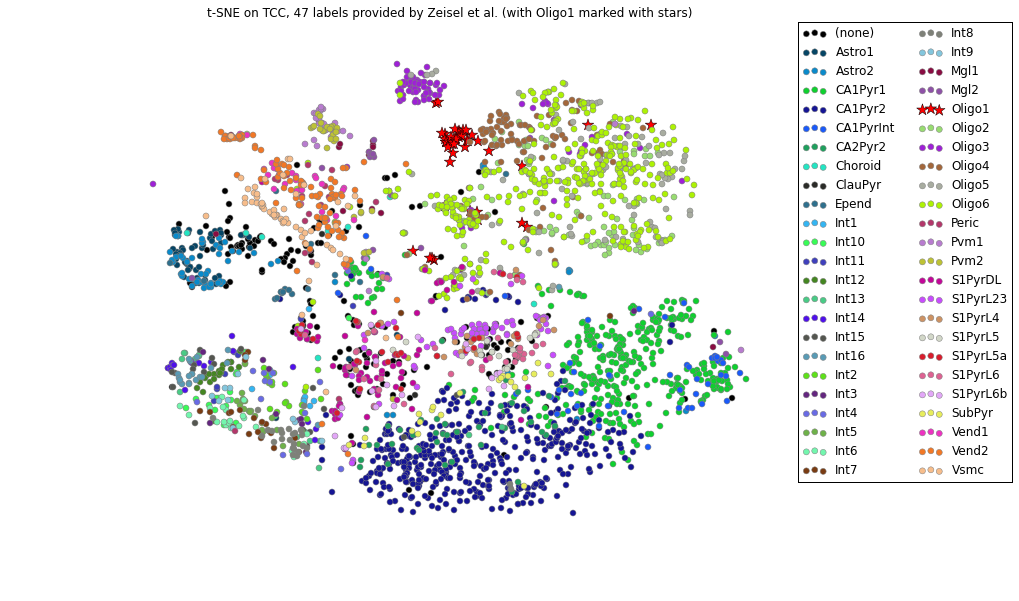

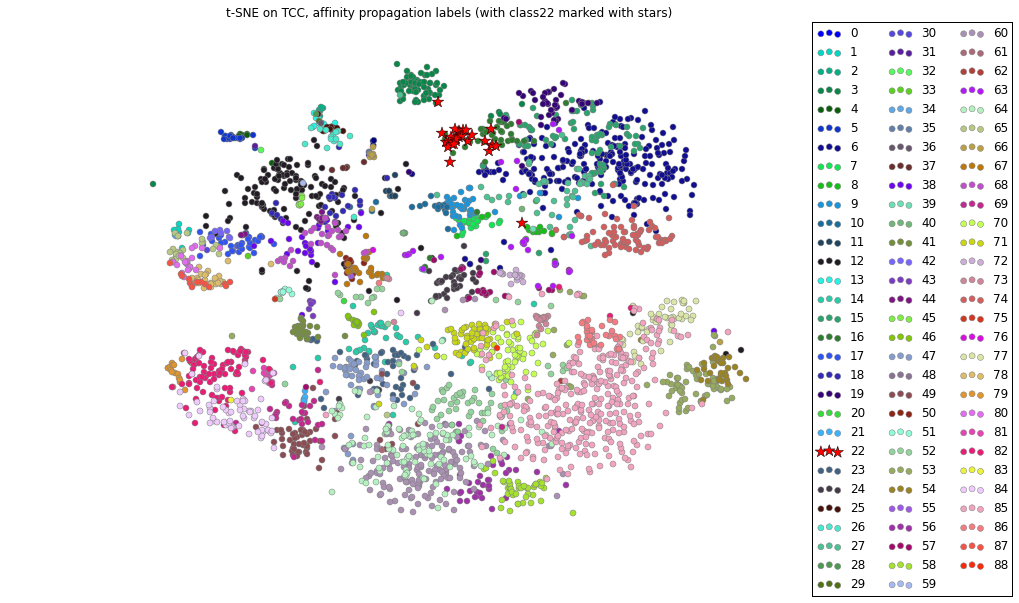

In [55]:
# Plot function with (nonrandom) colors corresponding to labels (star a specific label)
def stain_plot(X,labels,stain,title,nc=2):
    unique_labels = np.unique(labels)
    N = len(unique_labels)
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]    
    color= [(int(i[:2], 16)/float(255), int(i[2:4], 16)/float(255), 
             int(i[4:], 16)/float(255)) for i in colors]
    i=0;
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        if label in stain: 
            plt.scatter(X[ind,0],X[ind,1],c='red',s=146,edgecolors='black',
                        lw = 0.5, alpha=1,marker='*',label=label)
        else:
            plt.scatter(X[ind,0],X[ind,1],c=color[i],s=36,edgecolors='gray',
                        lw = 0.5,label=label)        
        i+=1   
    plt.title(title)
    plt.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=nc)
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.axis('off')

stain_plot(X_tsne,labels47,['Oligo1'],
           't-SNE on TCC, 47 labels provided by Zeisel et al. (with Oligo1 marked with stars)')
stain_plot(X_tsne,tcc_affinity_labels1,[22],
           't-SNE on TCC, affinity propagation labels (with class22 marked with stars)',3)

Next, we compare the expression of certain oligodendrocyte genes for the cells within cluster 22 to the expression of the same genes for the cells in Zeisel et al.'s Oligo1 group. We see that the bars are very similar (24 of the 28 cells in cluster 22 were in Zeisel's Oligo1 group). We used the gene counts from Zeisel et al.'s gene expression matrix. The relevant columns (corresponding to counts of a gene across all 3005 cells) are saved in the Zeisels_data folder.

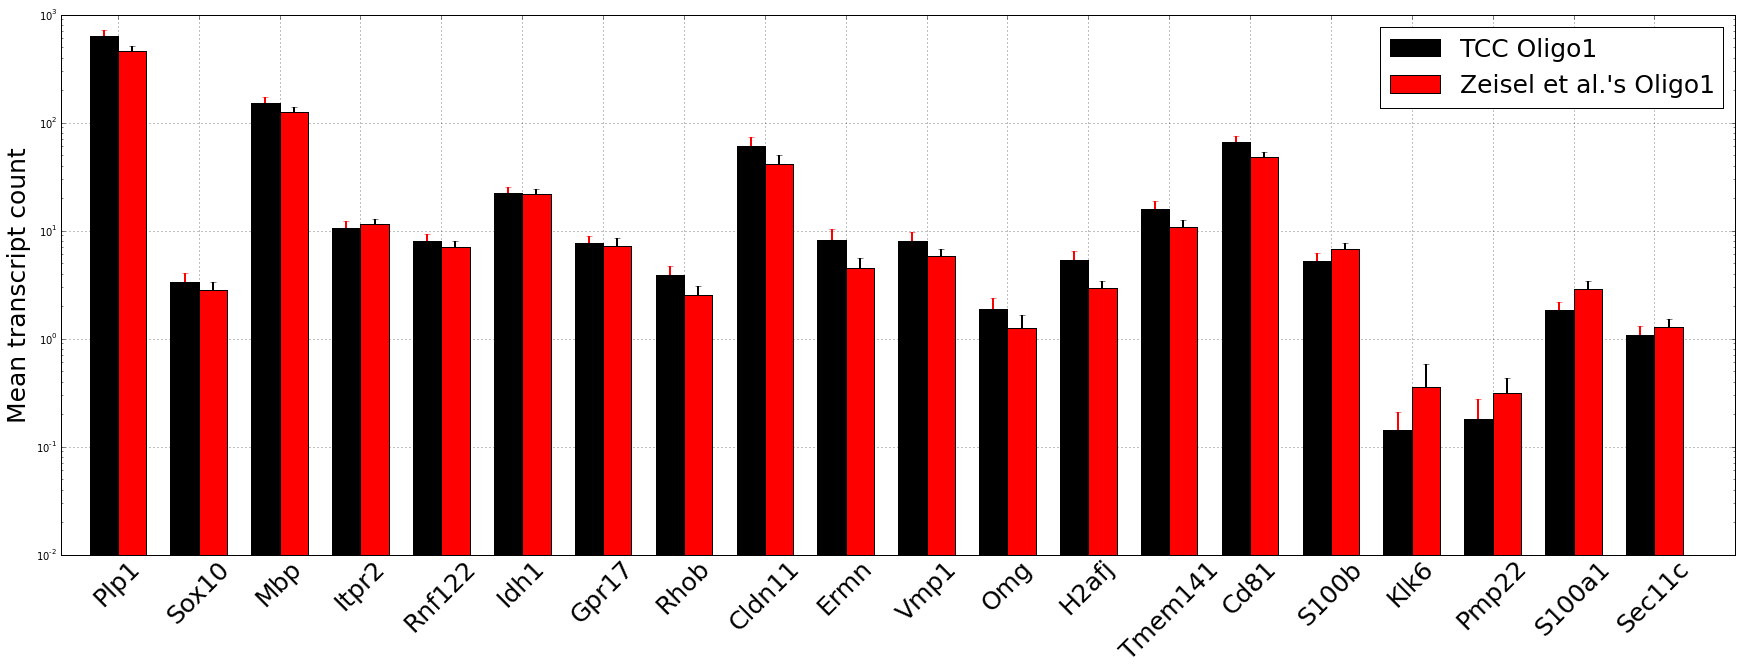

In [251]:
%matplotlib inline

# Compute means and std deviations of the Oligo genes
oligo_markers = ["Plp1", "Sox10", "Mbp", "Itpr2", "Rnf122", "Idh1", 
                  "Gpr17", "Rhob", "Cldn11","Ermn","Vmp1", "Omg", "H2afj", 
                  "Tmem141", "Cd81", "S100b", "Klk6", "Pmp22", "S100a1", "Sec11c"]
c22_means,zo1_means,c22_std,zo1_std = [],[],[],[]
n_c22 = np.sum(tcc_spectral_labels47 == 22)
n_zo1 = np.sum(labels47 == 'Oligo1')
for gn in oligo_markers:
    g = np.loadtxt('./Zeisels_data/'+gn+'_counts.txt')
    c22_means.append(np.mean(g[tcc_affinity_labels1 == 22]))
    zo1_means.append(np.mean(g[labels47 == 'Oligo1']))
    c22_std.append(np.std(g[tcc_affinity_labels1 == 22])/np.sqrt(n_c22))
    zo1_std.append(np.std(g[labels47 == 'Oligo1'])/np.sqrt(n_zo1))
    
# Generate the bar plot
fig = plt.figure(figsize=(30,10))
plt.gcf().subplots_adjust(bottom=0.15)
ax = fig.add_subplot(111)
ind = np.arange(len(oligo_markers))
width = 0.35
rects1 = ax.bar(ind,c22_means,width,color='black',yerr=c22_std,
                error_kw=dict(elinewidth=2,ecolor='red'),zorder=3)
rects2 = ax.bar(ind+width, zo1_means, width,color='red',yerr=zo1_std,
                error_kw=dict(elinewidth=2,ecolor='black'),zorder=3)
ax.set_xlim(-width,len(ind)+width)
xTickMarks = [i for i in oligo_markers]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=25)
ax.set_yscale('log')
plt.ylabel('Mean transcript count',size=25)
ax.legend( (rects1[0], rects2[0]), ('TCC Oligo1', 'Zeisel et al.\'s Oligo1') ,fontsize=25)
ax.grid()
plt.show()

## Oligo3  <a id='section4'></a>

We noticed that when we reduced the affinity-propagation preference parameter to below the median, affinity-propagation split Zeisel et al.'s Oligo3 group into two. We investigate further why this may be the case, or if there exists some biological justification of this. We first visualize Zeisel's Oligo3 and our divided Oligo3 clusters.

Converged after 32 iterations.


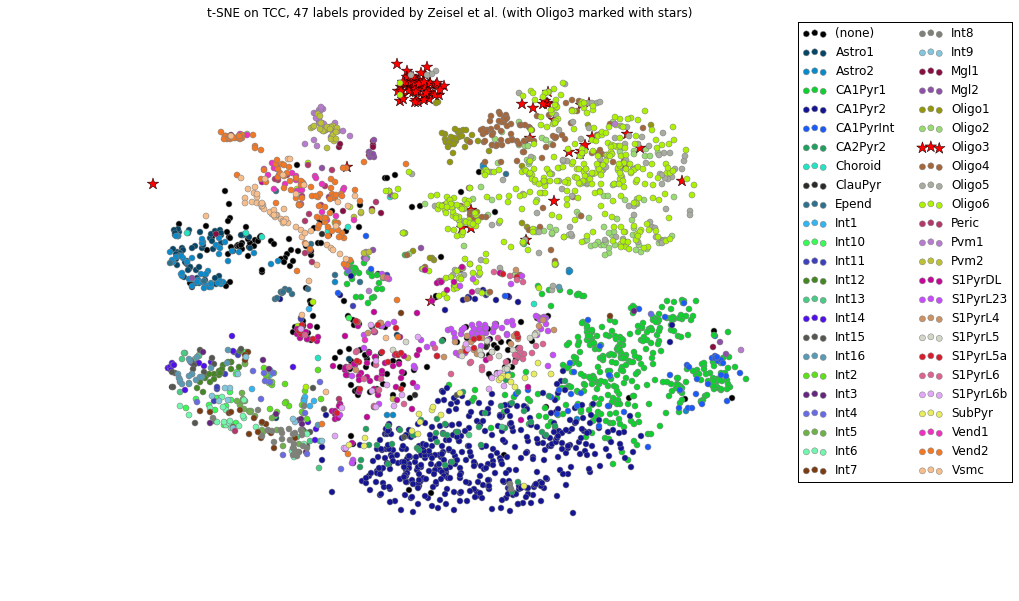

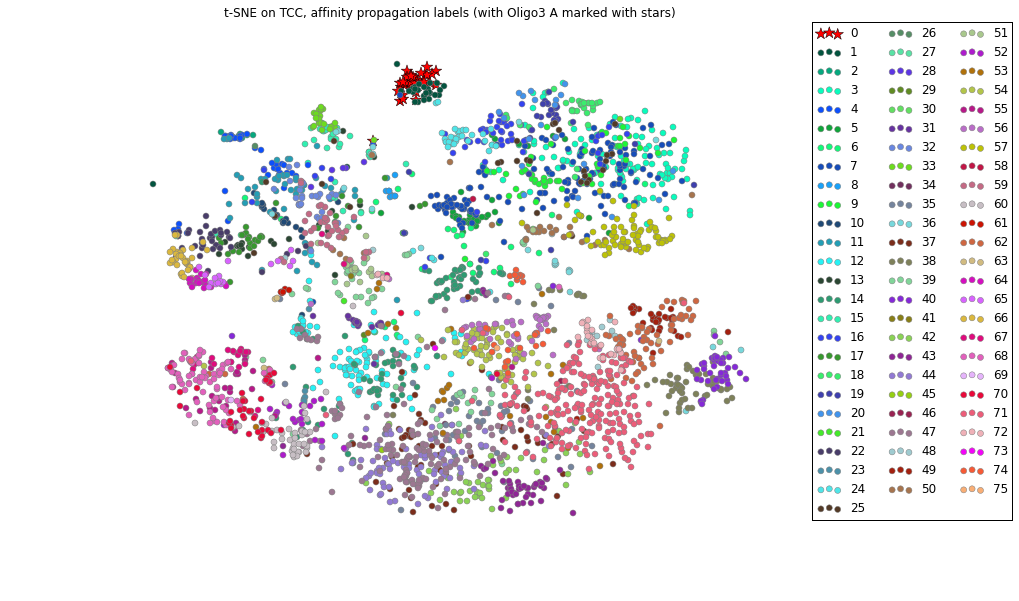

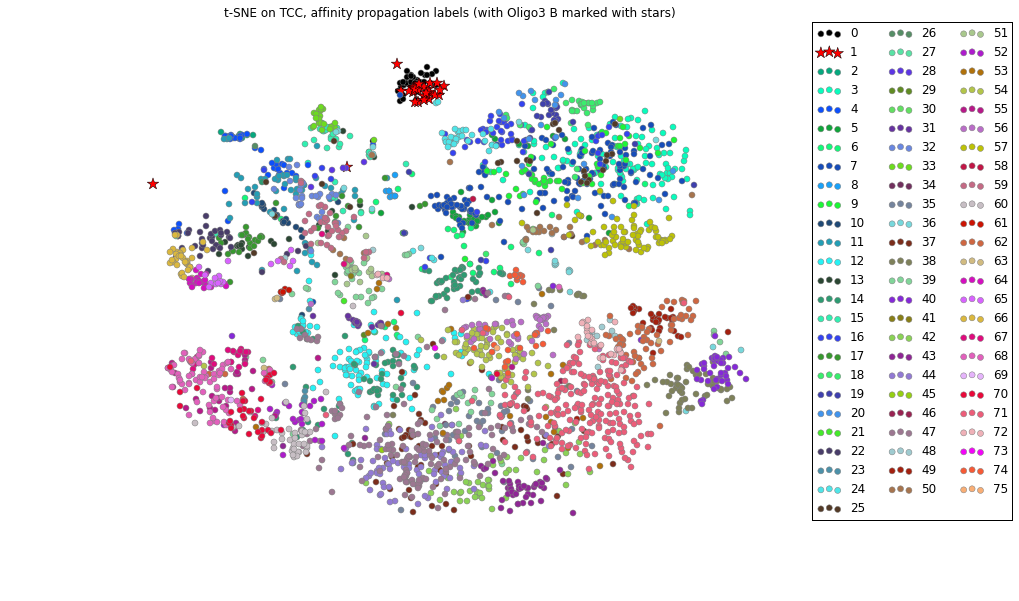

In [189]:
# We load in the TCC with UMI matrix generated by the pipeline
# D_umi = pickle.load(file('Zeisel_TCC_UMI_pairwise_JS_subsample100.dat','rb'))
D_umi = pickle.load(file('Zeisel_TCC_pairwise_JS_distance_wUMI_subsample100_full.dat','rb'))

pref = -0.635*np.ones(3005)
tcc_affinity_labels = AffinityProp(-D_umi,pref,0.65)

stain_plot(X_tsne,labels47,['Oligo3'],
           't-SNE on TCC, 47 labels provided by Zeisel et al. (with Oligo3 marked with stars)')
stain_plot(X_tsne,tcc_affinity_labels,[0],
           't-SNE on TCC, affinity propagation labels (with Oligo3 A marked with stars)',3)
stain_plot(X_tsne,tcc_affinity_labels,[1],
           't-SNE on TCC, affinity propagation labels (with Oligo3 B marked with stars)',3)

As suggested by Fan et al. in their [paper](http://biorxiv.org/content/biorxiv/early/2015/09/16/026948.full.pdf), we suspect that Oligo3 may be contaminated. We further investigate the expression level of certain endothelial/vascular genes and myelinating oligodendrocyte genes.

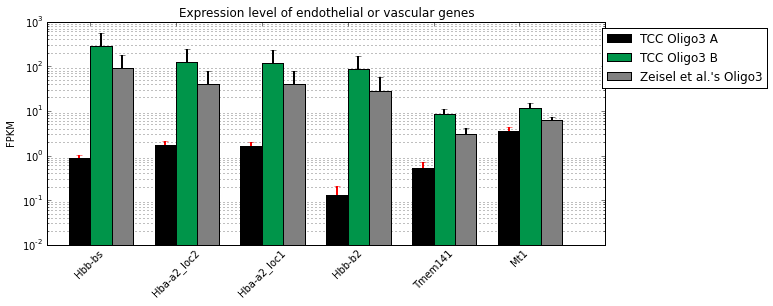

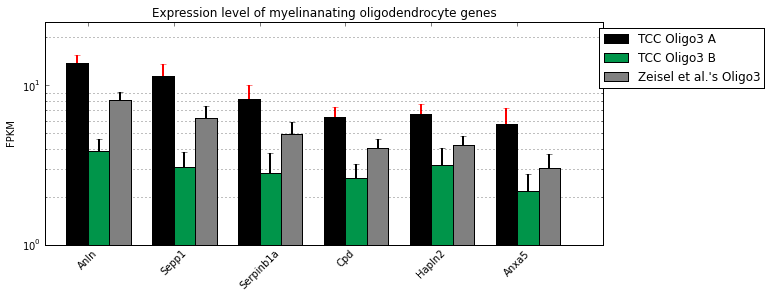

In [228]:
end_vas_genes = ["Hbb-bs","Hba-a2_loc2","Hba-a2_loc1","Hbb-b2","Tmem141","Mt1"]
mye_oli_genes = ["Anln","Sepp1","Serpinb1a","Cpd","Hapln2","Anxa5"]

def bar_plot_oligo3(genes,labels_true,labels_TCC,t,y1,y2):
    # Compute relevant means and standard errors for the 3 populations
    oZ_means,oA_means,oB_means,oZ_stds,oA_stds,oB_stds = [],[],[],[],[],[]
    for gn in genes:
        g = np.loadtxt('./Zeisels_data/'+gn+'_counts.txt')
        oZ_means.append(np.mean(g[labels_true=='Oligo3']))
        oA_means.append(np.mean(g[labels_TCC==0]))
        oB_means.append(np.mean(g[labels_TCC==1]))
        oZ_stds.append(np.std(g[labels_true=='Oligo3'])/np.sqrt(np.sum(labels_true=='Oligo3')))
        oA_stds.append(np.std(g[labels_TCC==0])/np.sqrt(np.sum(labels_TCC==0)))
        oB_stds.append(np.std(g[labels_TCC==1])/np.sqrt(np.sum(labels_TCC==1)))
    # Generate the bar plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ind = np.arange(len(genes))
    width = 0.25
    rects1 = ax.bar(ind,oA_means,width,color='black',yerr=oA_stds,
                    error_kw=dict(elinewidth=2,ecolor='red'),zorder=3)
    rects2 = ax.bar(ind+width,oB_means,width,color='#00954A',yerr=oB_stds,
                    error_kw=dict(elinewidth=2,ecolor='black'),zorder=3)
    rects3 = ax.bar(ind+2*width,oZ_means,width,color='gray',yerr=oZ_stds,
                    error_kw=dict(elinewidth=2,ecolor='black'),zorder=3)
    ax.set_xlim(-width,len(ind)+width)
    ax.set_ylim(y1,y2)
    ax.set_yticks([1,2,3,4,5,6,7,8,9,10,20])
    ax.set_yticklabels(['1','2','3','4','5','6','7','8','9','10','20'])
    ax.yaxis.grid(True, which='minor')
    xTickMarks = [i for i in genes]
    ax.set_xticks(ind+width)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=45)
    ax.set_yscale('log')
    plt.ylabel('FPKM')
    plt.title(t)
    ax.legend((rects1[0], rects2[0], rects3[0]), 
              ('TCC Oligo3 A', 'TCC Oligo3 B',"Zeisel et al.'s Oligo3"),
              bbox_to_anchor=(1.3, 1))
    plt.show()

bar_plot_oligo3(end_vas_genes,labels47,tcc_affinity_labels,
                'Expression level of endothelial or vascular genes',0.01,1000)
bar_plot_oligo3(mye_oli_genes,labels47,tcc_affinity_labels,
                'Expression level of myelinanating oligodendrocyte genes',1,25)

## Coverage Analysis <a id='section5'></a>

As an intermediate between raw reads and quantified transcript abundances, transcript-compatibility counts intuitively have more information than the reconstructed transcripts and less noise than the raw reads. To test the hypothesis that TCCs carry more information, we observed how clustering accuracy (see <a href='#section2'> Clustering Accuracy </a> section) changed with coverage (e.g. at 0.1%, 0.5%, 1%, 5%, and 10% of total reads).

In order to perform coverage analysis, the user must:

1. Align the reads
2. Subsample from the aligned reads (in the case of eXpress and UMI counting) or raw reads (in the case of psedoalignment methods)
3. Run the Zeisel pipeline (Zeisel_wrapper.py) on each of the subsampled matrices, resulting in multiple 3005-by-3005 distance matrices
4. Run the "run_mc_simulation" code on each of the distance matrices.

With our distance matrices already loaded in D_all, we run monte carlo simulations on all these matrices and compute the mean and standard errors along the way:

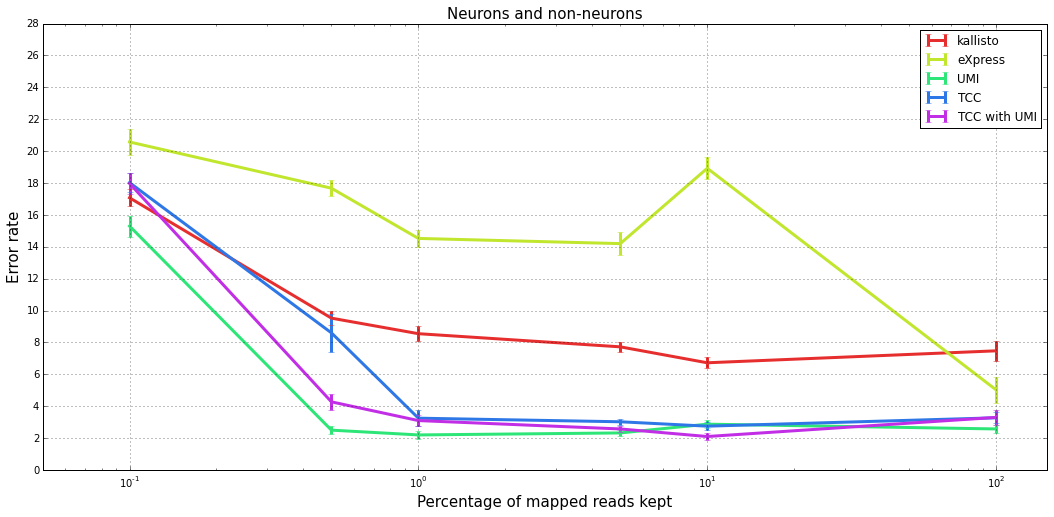

In [253]:
# Run simulations and compute means and standard errors of clustering accuracies
c_means,c_stds = np.zeros([nm,ns]),np.zeros([nm,ns])
for i,j in itertools.product(range(nm),range(ns)):
    D_temp = D_all[i][j]
    c = run_mc_simulation([0,1],labels2,D_temp)
    c_means[i,j] = np.mean(c)
    c_stds[i,j] = np.std(c)/np.sqrt(len(c))
    
# Plot the curves with standard errors
def plot_curve_set(means,stds,xpts,labels,t,max_y=30):
    N = np.shape(means)[0]
    HSVs = [(x*1.0/N, 0.8, 0.9) for x in range(N)]
    RGBs = map(lambda x: colorsys.hsv_to_rgb(*x), HSVs)
    ax = plt.figure(figsize=(18,8))
    ax = plt.subplot(111)
    for i in range(N):
        plt.errorbar(xpts,means[i],color=RGBs[i],yerr=stds[i],label=labels[i],linewidth=3)
    plt.xlim(0.05,150)
    plt.yticks(np.arange(0,max_y,2))
    ax.set_xscale('log')
    plt.grid()
    plt.xlabel('Percentage of mapped reads kept',size=15)
    plt.ylabel('Error rate',size=15)
    plt.title(t,size=15)
    plt.legend()
    plt.show()
    
plot_curve_set(c_means,c_stds,[0.1,.5,1,5,10,100],
              ['kallisto','eXpress','UMI','TCC','TCC with UMI'],
              'Neurons and non-neurons')

We also observe how Zeisel's clusters for the TCC matrix evolve as the coverage decreases. We visualize each distance matrix using t-SNE.

[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 3000 / 3005
[t-SNE] Computed conditional probabilities for sample 3005 / 3005
[t-SNE] Mean sigma: 0.082504
[t-SNE] Error after 65 iterations with early exaggeration: 22.858847
[t-SNE] Error after 141 iterations: 2.182714
[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 3000 / 3005
[t-SNE] Computed conditional probabilities for sample 3005 / 3005
[t-SNE] Mean sigma: 0.080843
[t-SNE] Error after 65 iterations with early exaggeration: 22.838543
[t-SNE] Error after 149 iterations: 2.387334
[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 

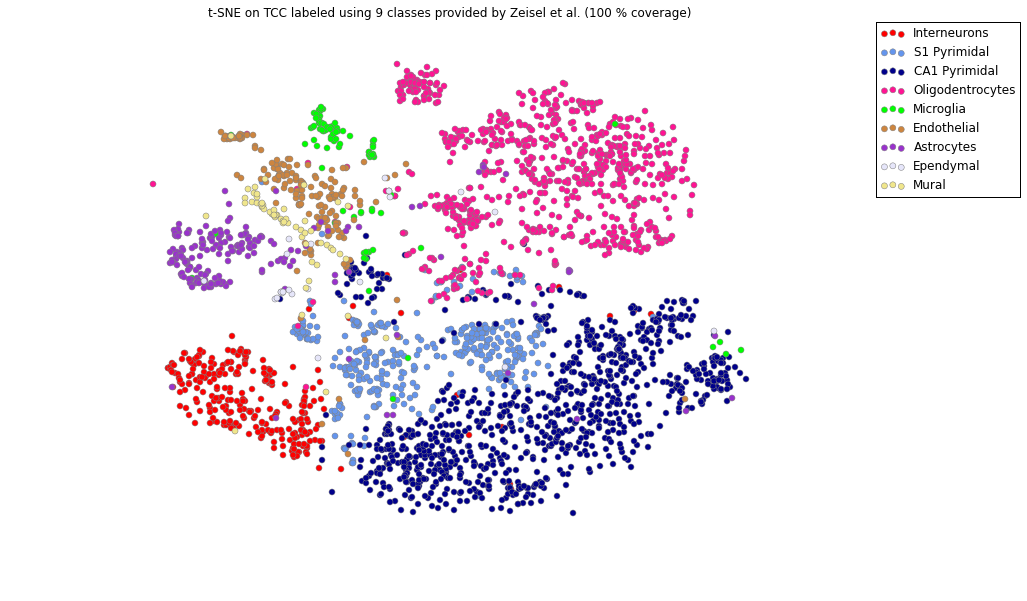

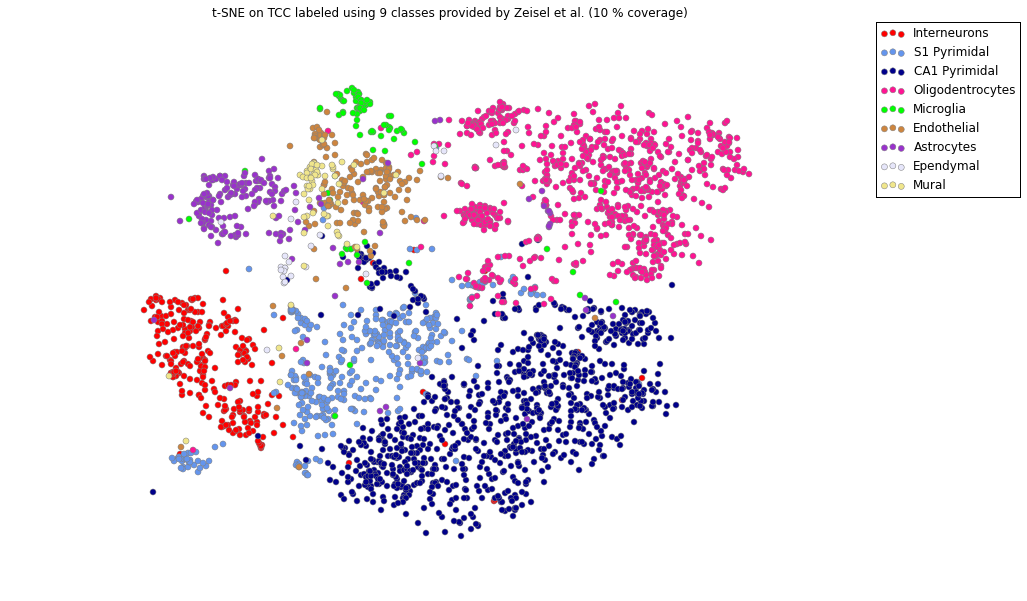

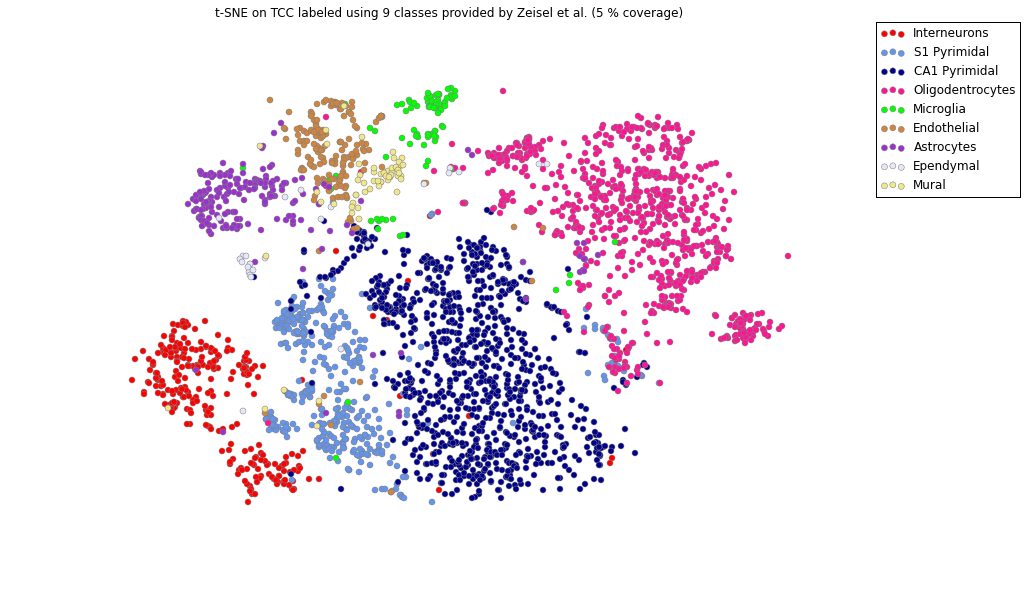

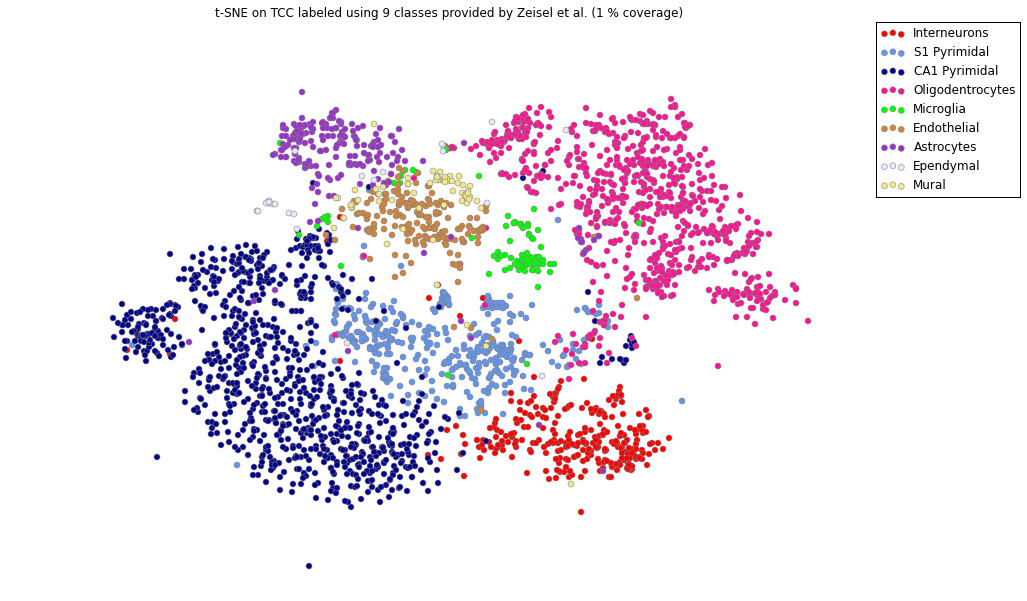

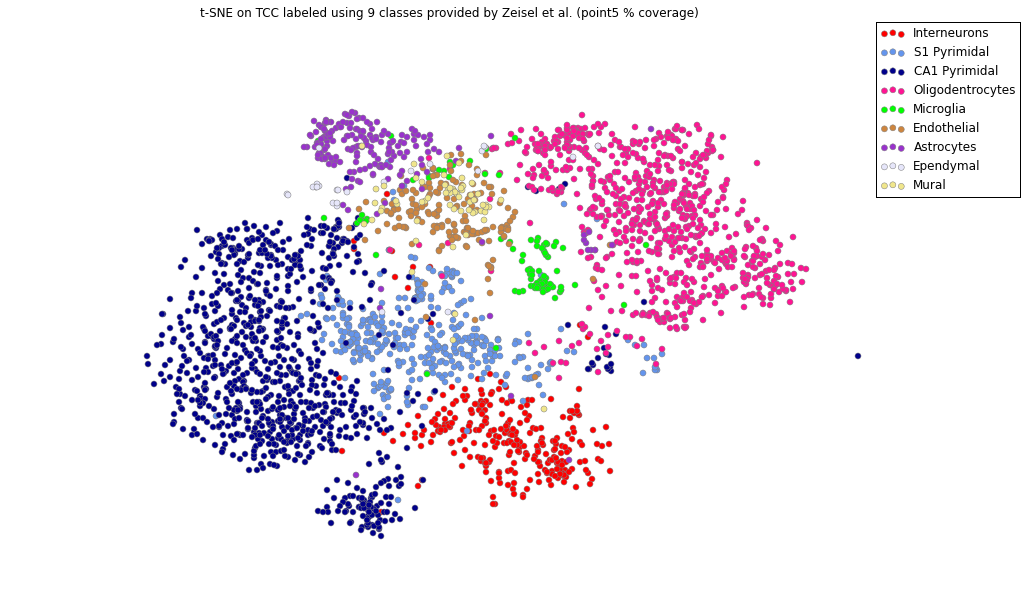

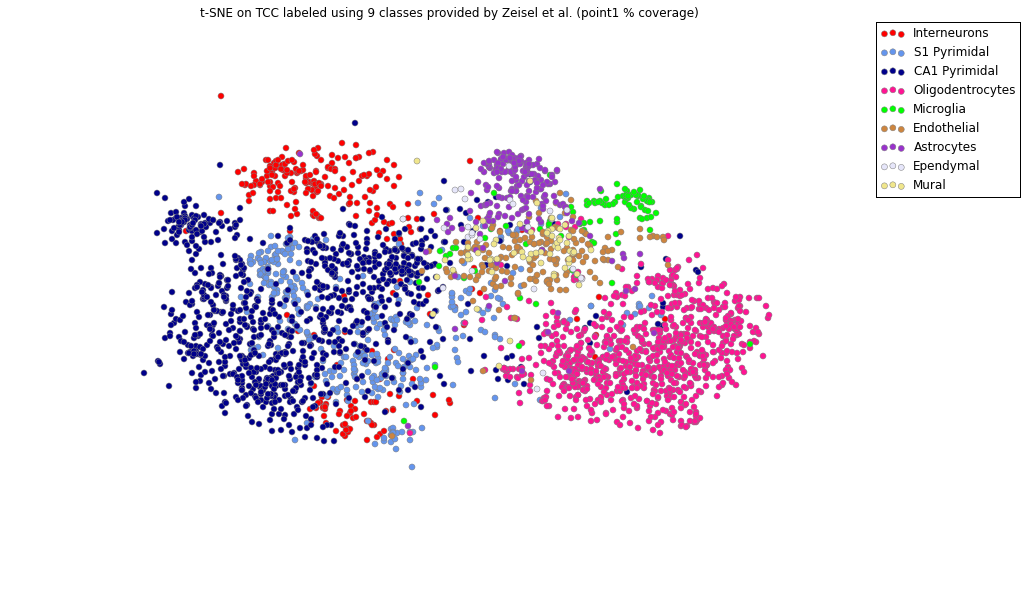

In [252]:
for i in range(ns):
    D_temp = D_all[3][-(i+1)]
    D_tSNE = tSNE_pairwise(D_temp)
    tru_plot9(D_tSNE,labels9,
         't-SNE on TCC labeled using 9 classes provided by Zeisel et al. ('+subsamplings[-(i+1)]+' % coverage)',
         clust_names = ['Interneurons','S1 Pyrimidal','CA1 Pyrimidal','Oligodentrocytes',
                   'Microglia','Endothelial','Astrocytes','Ependymal','Mural'],
         clust_color = ['red','cornflowerblue','darkblue','deeppink','lime',
                   'peru','darkorchid','lavender','khaki'])